In [7]:
import pandas as pd

# Load combined data
combined = pd.read_csv('combined_cleaned.csv', index_col='Date', parse_dates=True)

# Calculate daily returns
returns = combined[['Close_TSLA', 'Close_BND', 'Close_SPY']].pct_change().dropna()
returns.columns = ['TSLA_Returns', 'BND_Returns', 'SPY_Returns']


In [8]:
# Forecasted return from LSTM (Task-2 result)
forecasted_tsla_return_daily = 0.0015  # adjust based on your Task-2 results
forecasted_tsla_return_annual = forecasted_tsla_return_daily * 252  # annualized

# Historical average daily returns
historical_daily_returns = returns.mean()

# Annualized returns
expected_returns = {
    'TSLA': forecasted_tsla_return_annual,
    'BND': historical_daily_returns['BND_Returns'] * 252,
    'SPY': historical_daily_returns['SPY_Returns'] * 252
}


In [9]:
# Annualized covariance matrix
cov_matrix = returns.cov() * 252


In [11]:
import numpy as np

assets = ['TSLA_Returns', 'BND_Returns', 'SPY_Returns']
returns_vec = np.array([expected_returns[asset.replace('_Returns', '')] for asset in assets])
cov_mat = cov_matrix.loc[assets, assets].values

def portfolio_performance(weights, returns, cov_matrix):
    ret = np.dot(weights, returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = ret / vol
    return ret, vol, sharpe

def negative_sharpe(weights, returns, cov_matrix):
    return -portfolio_performance(weights, returns, cov_matrix)[2]

def portfolio_volatility(weights, returns, cov_matrix):
    return portfolio_performance(weights, returns, cov_matrix)[1]

In [12]:
# Constraints and bounds
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(len(assets)))
initial_guess = [1/3, 1/3, 1/3]

# Max Sharpe Ratio Portfolio
opt_sharpe = minimize(negative_sharpe, initial_guess,
                      args=(returns_vec, cov_mat),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

# Min Volatility Portfolio
opt_min_vol = minimize(portfolio_volatility, initial_guess,
                       args=(returns_vec, cov_mat),
                       method='SLSQP',
                       bounds=bounds,
                       constraints=constraints)


In [13]:
target_returns = np.linspace(0.05, 0.35, 50)
frontier_volatility = []

for r in target_returns:
    constraints_frontier = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, returns_vec) - r}
    )
    result = minimize(portfolio_volatility, initial_guess,
                      args=(returns_vec, cov_mat),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints_frontier)
    if result.success:
        frontier_volatility.append(result.fun)
    else:
        frontier_volatility.append(np.nan)


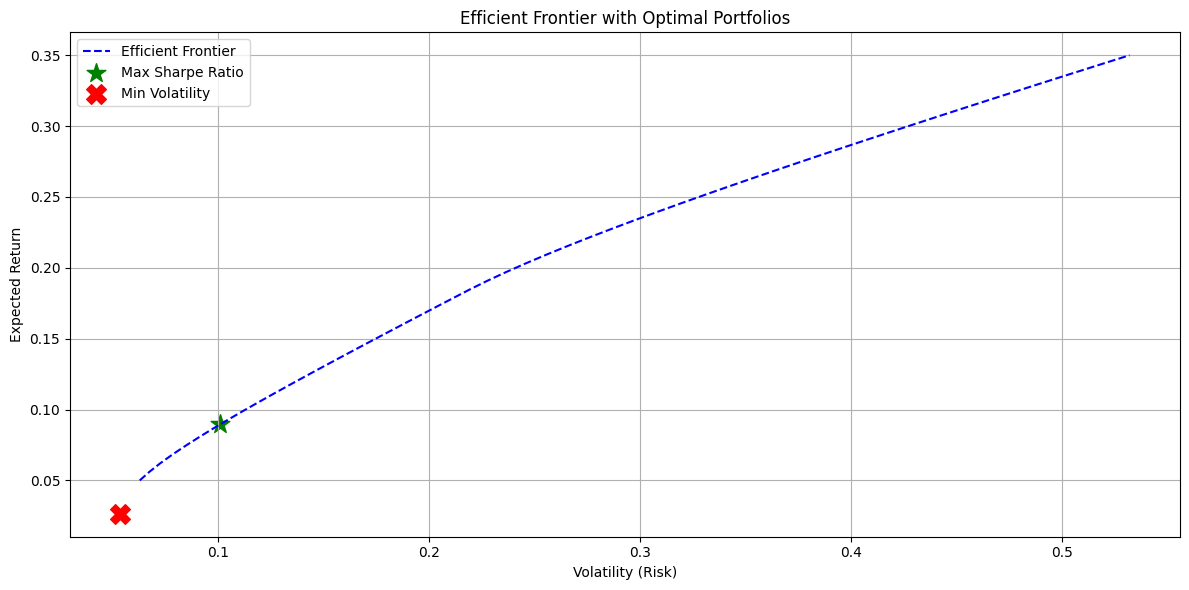

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(frontier_volatility, target_returns, 'b--', label='Efficient Frontier')
plt.scatter(*portfolio_performance(opt_sharpe.x, returns_vec, cov_mat)[1::-1],
            c='green', marker='*', s=200, label='Max Sharpe Ratio')
plt.scatter(*portfolio_performance(opt_min_vol.x, returns_vec, cov_mat)[1::-1],
            c='red', marker='X', s=200, label='Min Volatility')

plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Optimal Portfolios')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
def print_portfolio(name, result):
    ret, vol, sharpe = portfolio_performance(result.x, returns_vec, cov_mat)
    print(f"\n📌 {name} Portfolio:")
    print(f"Weights: {dict(zip(assets, np.round(result.x, 3)))}")
    print(f"Expected Annual Return: {ret:.2%}")
    print(f"Volatility: {vol:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")

print_portfolio("Maximum Sharpe Ratio", opt_sharpe)
print_portfolio("Minimum Volatility", opt_min_vol)



📌 Maximum Sharpe Ratio Portfolio:
Weights: {'TSLA_Returns': np.float64(0.063), 'BND_Returns': np.float64(0.56), 'SPY_Returns': np.float64(0.377)}
Expected Annual Return: 8.95%
Volatility: 10.11%
Sharpe Ratio: 0.89

📌 Minimum Volatility Portfolio:
Weights: {'TSLA_Returns': np.float64(0.0), 'BND_Returns': np.float64(0.945), 'SPY_Returns': np.float64(0.055)}
Expected Annual Return: 2.65%
Volatility: 5.40%
Sharpe Ratio: 0.49
